In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.pylab import plt
import seaborn as sns

In [24]:
movies_df = pd.read_csv("movies_with_franchises.csv", index_col = 0)
games_df = pd.read_csv("clean_games_with_franchises.csv", index_col = 0)

D:\Programs\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,3,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Naming convention to standardise the column names

In [25]:
games_df = games_df.rename(columns = {"titleType": "type", "rating": "age_rating", "startYear": "year", "primaryTitle": "title", "averageRating": "rating", "numVotes": "votes", "isAdult" : "is_adult"})
movies_df = movies_df.rename(columns={"startYear": "year", "primaryTitle": "title", "isAdult" : "is_adult", "runtimeMinutes": "runtime", "averageRating": "rating", "numVotes": "votes"})
movies_df = movies_df[["franchise_name", "franchise_id", "tconst", "title", "year", "is_adult", "runtime", "genres", "rating", "votes"]]

In [26]:
movies_df["type"] = "movie"
games_df["type"] = "game"

In [13]:
complete_df = pd.concat([movies_df, games_df])

franchise_name     16995
franchise_id       16995
tconst            307416
title             307416
year              307416
is_adult          307416
runtime           290426
genres            307416
rating            307416
votes             307416
type              307416
game_id            11209
best_fit_ratio     16990
developers         11035
platforms          11192
publishers         11080
age_rating          7470
dtype: int64

- Normalize movies and games 
- Calculate z-scores
- Add the following headings\
    &emsp;"Time until next movie"\
    &emsp;"Difference in rating"
    
    &emsp;"Number in Franchise"

Get number of movies/games in franchise

In [28]:
complete_df['franchise_count'] = complete_df['franchise_id'].map(complete_df['franchise_id'].value_counts())

In [23]:
movies_df['franchise_count'] = movies_df['franchise_id'].map(movies_df['franchise_id'].value_counts())
games_df['franchise_count'] = games_df['franchise_id'].map(games_df['franchise_id'].value_counts())
movies_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,franchise_count
76544,NaN,NaN,tt0152098,psi factor,1980,0,91,"Mystery,Sci-Fi",4.9,88.0,movie,NaN


Get an overview of how many franchises have x amount of movies / games

In [ ]:
movies_df["franchise_id"].value_counts().value_counts().sort_index()

In [ ]:
games_df["franchise_id"].value_counts().value_counts().sort_index()

Get total number of franchises:

In [ ]:
movies_df.franchise_id.nunique()

In [ ]:
games_df.franchise_id.nunique()

Remove any movies or games where the total franchise count after matching the series is less than 3

In [31]:
complete_df[["franchise_id", "franchise_name", "franchise_count"]] = complete_df[["franchise_id", "franchise_name", "franchise_count"]].apply(lambda x: np.nan if x["franchise_count"] < 3 else x, axis=1)

In [ ]:
movies_df[["franchise_id", "franchise_name", "franchise_count"]] = movies_df[["franchise_id", "franchise_name", "franchise_count"]].apply(lambda x: np.nan if x["franchise_count"] < 3 else x, axis=1).sort_values("franchise_count")
games_df[["franchise_id", "franchise_name", "franchise_count"]] = games_df[["franchise_id", "franchise_name", "franchise_count"]].apply(lambda x: np.nan if x["franchise_count"] < 3 else x, axis=1).sort_values("franchise_count")

Get total number of franchises with more than 3:

In [34]:
complete_df[complete_df["type"] == "movie"].franchise_id.nunique()

857

In [35]:
complete_df[complete_df["type"] == "game"].franchise_id.nunique()

1157

In [ ]:
movies_df.franchise_id.nunique()

In [ ]:
games_df.franchise_id.nunique()

Remove non-numerical years from data and convert to int

In [36]:
complete_df = complete_df[~(complete_df["year"] == "\\N")]
complete_df["year"] = complete_df["year"].apply(lambda x: int(x))

<ipython-input-36-a7b0c9624dc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["year"] = complete_df["year"].apply(lambda x: int(x))


In [ ]:
movies_df = movies_df[~(movies_df["year"] == "\\N")]
games_df = games_df[~(games_df["year"] == "\\N")]
movies_df["year"] = movies_df["year"].apply(lambda x: int(x))
games_df["year"] = games_df["year"].apply(lambda x: int(x))

In [38]:
complete_df

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count
0,Coffin Joe,f1,tt0060380,esta noite encarnarei no teu cadáver,1967,0,108,Horror,7.0,1952.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
1,Coffin' Joe,f822,tt0060380,esta noite encarnarei no teu cadáver,1967,0,108,Horror,7.0,1952.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,Coffin Joe,f1,tt0062943,the strange world of coffin joe,1968,0,80,Horror,6.3,653.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
3,Coffin Joe,f1,tt0062690,awakening of the beast,1970,0,93,"Drama,Horror",5.8,1208.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
4,Coffin Joe,f1,tt0071479,exorcismo negro,1974,0,100,Horror,6.0,274.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,NaN,NaN,tt9888864,Infernal,2007,0,NaN,['Action'],6.0,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN
16986,NaN,NaN,tt9892552,Spiral Splatter,2017,0,NaN,['Action'],2.0,10.0,game,NaN,85.5,NaN,NaN,NaN,NaN,NaN
16987,NaN,NaN,tt9893348,Alien: Covenant In Utero VR Experience,2017,0,NaN,['Sci-Fi'],6.2,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN
16988,LEGO,3025-448,tt9893804,The Lego Movie 2 Videogame,2019,0,NaN,"['Animation', 'Adventure', 'Family', 'Action-A...",5.5,156.0,game,22035.0,100.0,['TT Games'],"['PC', 'Xbox One', 'PlayStation 4', 'Nintendo ...",['WB Games'],NaN,56.0


## Splitting the data
At this stage we are going to create 2 separate dataframes. The first will group all the franchises by year, and each year for each franchise will be a single entry. The second will keep all the individual entries for each year for each franchise. 

### Single Year Per Franchise

Create a copy

In [109]:
merged_years_df = complete_df.copy(deep=True)

Convert genres to list

In [110]:
merged_years_df["genres"] = merged_years_df.genres.apply(lambda x : x.split(','))

Get total for each year, for each franchise

In [111]:
merged_years_df['content_per_year'] = merged_years_df.groupby(["franchise_id", "year"])["year"].transform('count')

Create average votes and ratings for each franchise

In [112]:
grouped_movies = merged_years_df.groupby(["franchise_id", "year"]).agg({"votes": "mean", "rating": "mean"}).reset_index()
merged_years_df = pd.merge(merged_years_df, grouped_movies, on=["franchise_id", "year"], how="left", suffixes=(None, '_average'))

In [113]:
# group by name and release year, aggregate the franchise_id lists
merged_years_df = merged_years_df.groupby(['franchise_id', 'year'], as_index=False).agg(({
    'franchise_name': 'first',
    'franchise_id': 'first',
    "type": "first",
    'tconst': ", ".join,
    'title': ", ".join,
    "year": 'first',
    "is_adult": "first",
    "runtime" : "first",
    "genres": lambda x: list(set([i for l in x for i in l])),
    "votes_average": "first", 
    "rating_average": "first", 
    "franchise_count" : "first",
    "content_per_year": "first", 
    }))

Create columns that have the difference in year between the previous entries in the franchise, the difference in average vote count and avaerage rating

In [118]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,year_franchise_movies_total,year_difference,year_diff
8541,The Three Mesquiteers,f1337,movie,"tt0036437, tt0035683, tt0036332, tt0036312","thundering trails, the blocked trail, santa fe...",1943,0,60,[Western],62.0,7.05,52.0,4.0,1.0,1.0


In [119]:
merged_years_df = merged_years_df.sort_values(["franchise_id", "year"])
merged_years_df['year_diff'] = merged_years_df.groupby(['franchise_id'])['year'].diff()
merged_years_df['vote_diff'] = merged_years_df.groupby(['franchise_id'])['votes_average'].diff()
merged_years_df['rating_diff'] = merged_years_df.groupby(['franchise_id'])['rating_average'].diff()
merged_years_df['num_of_releases_diff'] = merged_years_df.groupby(['franchise_id'])['content_per_year'].diff()

In [122]:
merged_years_df

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,year_franchise_movies_total,year_difference,year_diff,vote_diff,rating_diff,num_of_releases_diff
0,Mario,3025-1,game,tt0315808,Baseball,1978,0,NaN,"[ 'Baseball', ['Sport', 'Family', 'Sports']]",13.0,3.00,195.0,1.0,NaN,NaN,NaN,NaN,NaN
1,Mario,3025-1,game,tt0176664,Donkey Kong,1981,0,NaN,"[['Action', 'Platformer']]",2011.0,7.40,195.0,1.0,3.0,3.0,1998.0,4.40,0.0
2,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,0,NaN,"[ 'Family'], ['Action', 'Platformer']",170.5,6.50,195.0,2.0,1.0,1.0,-1840.5,-0.90,1.0
3,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,0,NaN,"[ 'Fantasy'], 'Platformer'], ['\\N'], 'Sport...",326.8,6.00,195.0,5.0,1.0,1.0,156.3,-0.50,3.0
4,Mario,3025-1,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,0,NaN,"[['Puzzle', 'Sports'], 'Platformer', ['Golf'...",49.5,5.85,195.0,4.0,1.0,1.0,-277.3,-0.15,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,Renato Castellani's Italian neorealism trilogy,f993,movie,tt0040018,it's forever springtime,1950,0,92,"[Comedy, Drama]",99.0,6.40,3.0,1.0,2.0,2.0,-212.0,-0.50,0.0
11379,Renato Castellani's Italian neorealism trilogy,f993,movie,tt0044572,two cents worth of hope,1952,0,110,"[Romance, Comedy]",658.0,7.00,3.0,1.0,2.0,2.0,559.0,0.60,0.0
11380,It's Alive,f994,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"[Sci-Fi, Romance, Horror]",5449.5,4.25,4.0,2.0,NaN,NaN,NaN,NaN,NaN
11381,It's Alive,f994,movie,tt0077756,it lives again,1978,0,91,"[Sci-Fi, Horror]",2494.0,5.20,4.0,1.0,4.0,4.0,-2955.5,0.95,-1.0


At this stage, the merged_year_df contains all the movies within a franchise, grouped by year of release for each franchise, with columns that show how the number of releases, rating and vote count changed from the previous release year, and the number of years between subsequent releases. We'll export this information as a csv

In [129]:
merged_years_df.to_csv("franchises_combined_by_year.csv")

In [127]:
merged_years_df["year_diff"].describe()

count    9369.000000
mean        3.261714
std         4.967059
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        83.000000
Name: year_diff, dtype: float64

### Returning to our original dataframe

Create additional columns for the datasets containing average rating for the franchises

In [ ]:
#av_vote_year = movies_df.groupby(['franchise_id', 'year'])['rating'].mean().reset_index(drop=False)
#movies_df = movies_df.merge(av_vote_year[['franchise_id', 'year', 'rating']], on=['franchise_id', 'year'], how = "outer", suffixes=(None, '_franchise_average'))
#av_vote_year = games_df.groupby(['franchise_id', 'year'])['rating'].mean().reset_index(drop=False)
#games_df = games_df.merge(av_vote_year[['franchise_id', 'year', 'rating']], on=['franchise_id', 'year'], how = "outer", suffixes=(None, '_franchise_average'))


In [ ]:
movies_df = movies_df.sort_values(['franchise_id', 'year'])
movies_df['Year Gap'] = movies_df.groupby('franchise_id')['year'].diff()
movies_df['Rating_Difference'] = movies_df.groupby('franchise_id')['rating'].diff()
movies_df['Votes_Difference'] = movies_df.groupby('franchise_id')['votes'].diff()

In [ ]:
#movies_df['AAAAHH'] = movies_df.groupby(['franchise_id','year'])['year'].diff()
movies_df['year_diff'] = movies_df.groupby(['franchise_id', 'year'])['year'].diff().reset_index(drop=True)

In [ ]:
movies_df['year_difference'] = movies_df.groupby(['franchise_id', 'year'])['year'].diff()

# exclude same year differences
movies_df.loc[movies_df['year_difference'] == 0, 'year_difference'] = pd.NA

In [ ]:
movies_df = movies_df.sort_values(['franchise_id', 'startYear'])
movies_df['Rating_Difference'] = movies_df.groupby('franchise_id')['averageRating'].diff()

In [ ]:
movies_df = movies_df.sort_values(['franchise_id', 'startYear'])
movies_df['Votes_Difference'] = movies_df.groupby('franchise_id')['numVotes'].diff()

In [ ]:
movies_df['franchise_position'] = movies_df.groupby("franchise_id")["startYear"].rank(method="first")

In [ ]:
movies_df.groupby(['franchise_id', 'startYear']).size()

In [ ]:
movies_df["Year Gap"].value_counts().plot()

# Notes
Using value_counts we discover 25% of our movies for the franchises are released in the same year. So we have to either get an average per year (in this case, we are looking at fatique over years as opposed to number of movies)

In [134]:
complete_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count
219112,NaN,NaN,tt2375565,super awesome!,2015,0,89,"Comedy,Musical",5.9,52.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
cols = ["tconst", "rating", "votes", "year"]

games_scores = complete_df[complete_df["type"] == "game"][cols]

movies_scores = complete_df[complete_df["type"] == "movie"][cols]

In [136]:
%matplotlib inline

sns.set_context("talk", font_scale=.9)   
sns.set_context('talk')

fig_width, fig_height = 4, 3

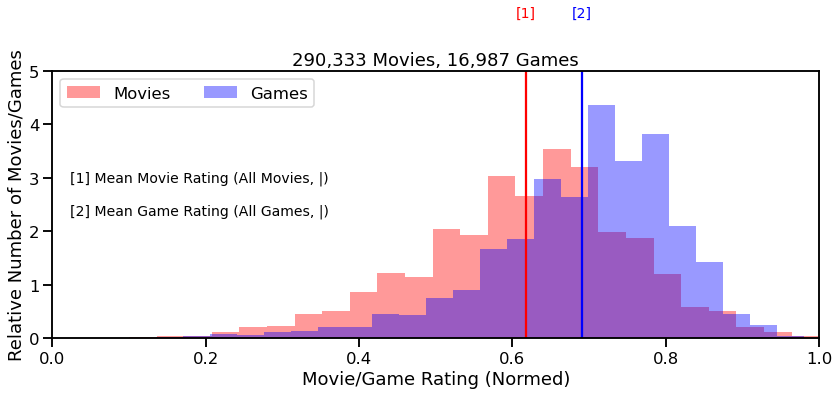

In [138]:
fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))

interval = 0.01
((movies_scores['rating']/10)).hist(
    bins=25, ax=ax, grid=False, color="red", density=True, alpha=.4)
((games_scores['rating']/10)).hist(
    bins=25, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_ylim(0, 5)
ax.set_xlim(0, 1)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

mean_movie_rating = (movies_scores['rating']/10).mean()
mean_game_rating = (games_scores['rating']/10).mean()

ax.axvline(mean_movie_rating, color="red")
ax.axvline(mean_game_rating, color="blue")

ax.text(mean_movie_rating, 6, '[1]', ha='center',color="red", backgroundcolor='w', fontsize=14)

ax.text(mean_game_rating, 6, '[2]', ha='center',color="blue", backgroundcolor='w', fontsize=14)


ax.text(
    0, 2,
    '''
    [1] Mean Movie Rating (All Movies, |)
    
    [2] Mean Game Rating (All Games, |)
    ''',
    fontsize=14
)

ax.set_xlabel('Movie/Game Rating (Normed)')
ax.set_ylabel('Relative Number of Movies/Games')

ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_scores), len(games_scores)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_1_normed_rating_distributions.png', format='png', dpi=300)

In [140]:
complete_df[complete_df["type"] == "movie"]['rating'].agg(['mean', 'std'])

mean    6.175676
std     1.363040
Name: rating, dtype: float64

In [143]:
(complete_df[complete_df["type"] == "movie"]['rating']-complete_df[complete_df["type"] == "movie"]['rating'].mean())/complete_df[complete_df["type"] == "movie"]['rating'].std()

0         0.604769
1         0.604769
2         0.091211
3        -0.275616
4        -0.128886
            ...   
290421   -0.275616
290422    0.164576
290423   -1.742925
290424    1.778615
290425    1.558519
Name: rating, Length: 290333, dtype: float64

In [144]:
stats.zscore(complete_df[complete_df["type"] == "movie"]['rating'])

array([ 0.60476958,  0.60476958,  0.09121082, ..., -1.7429276 ,
        1.77861817,  1.55852155])

In [145]:
stats.zscore(complete_df[complete_df["type"] == "movie"]['rating']).mean()

-1.114664176753229e-15

In [150]:
complete_df["z_rating"] = np.nan

<ipython-input-150-191b59c0b11c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["z_rating"] = np.nan


In [154]:
complete_df[complete_df["type"] == "movie"]['z_rating'] = stats.zscore(complete_df[complete_df["type"] == "movie"]['rating'])
complete_df.sort_values("z_rating")

<ipython-input-154-147dd0fe079a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df[complete_df["type"] == "movie"]['z_rating'] = stats.zscore(complete_df[complete_df["type"] == "movie"]['rating'])


,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count,z_rating
0,Coffin Joe,f1,tt0060380,esta noite encarnarei no teu cadáver,1967,0,108,Horror,7.0,1952.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
1,Coffin' Joe,f822,tt0060380,esta noite encarnarei no teu cadáver,1967,0,108,Horror,7.0,1952.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
2,Coffin Joe,f1,tt0062943,the strange world of coffin joe,1968,0,80,Horror,6.3,653.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
3,Coffin Joe,f1,tt0062690,awakening of the beast,1970,0,93,"Drama,Horror",5.8,1208.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
4,Coffin Joe,f1,tt0071479,exorcismo negro,1974,0,100,Horror,6.0,274.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,NaN,NaN,tt9888864,Infernal,2007,0,NaN,['Action'],6.0,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN
16986,NaN,NaN,tt9892552,Spiral Splatter,2017,0,NaN,['Action'],2.0,10.0,game,NaN,85.5,NaN,NaN,NaN,NaN,NaN,NaN
16987,NaN,NaN,tt9893348,Alien: Covenant In Utero VR Experience,2017,0,NaN,['Sci-Fi'],6.2,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN
16988,LEGO,3025-448,tt9893804,The Lego Movie 2 Videogame,2019,0,NaN,"['Animation', 'Adventure', 'Family', 'Action-A...",5.5,156.0,game,22035.0,100.0,['TT Games'],"['PC', 'Xbox One', 'PlayStation 4', 'Nintendo ...",['WB Games'],NaN,56.0,NaN


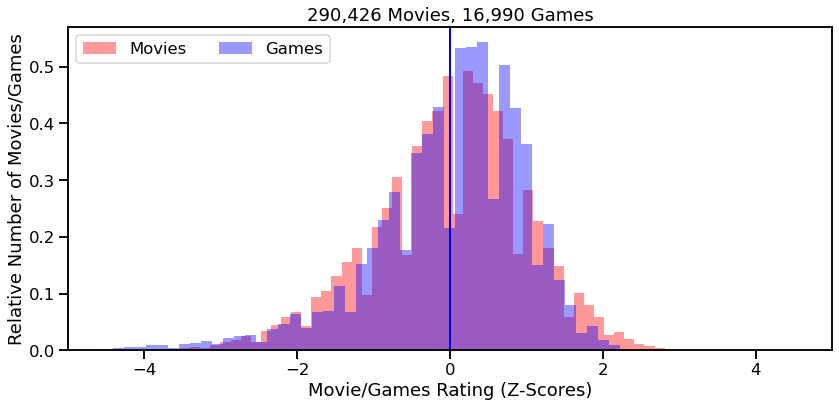

In [159]:
complete_df.loc[complete_df["type"] == "movie", 'z_rating'] = stats.zscore(complete_df.loc[complete_df["type"] == "movie", 'rating'])

complete_df.loc[complete_df["type"] == "game", 'z_rating'] = stats.zscore(complete_df.loc[complete_df["type"] == "game", 'rating'])

fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))


((complete_df[complete_df["type"] == "movie"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="red", density=True, alpha=.4)
((complete_df[complete_df["type"] == "game"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_xlim(-5, 5)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

ax.axvline((complete_df[complete_df["type"] == "movie"]['z_rating']).mean(), lw=2, c="red")
ax.axvline((complete_df[complete_df["type"] == "game"]['z_rating']).mean(), lw=2, c="blue")


ax.set_xlabel('Movie/Games Rating (Z-Scores)')
ax.set_ylabel('Relative Number of Movies/Games')
ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_df), len(games_df)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_2_z_rating_distributions.png', format='png', dpi=300)

## Additional Unused Code

In [ ]:
def sample_func(sub_df):
    
    movies_in_order = sub_df.sort_values('year')['tconst']
    return pd.Series({movie: k+1 for k, movie in enumerate(movies_in_order)})

In [ ]:
sample_df = movies_df.sample(10000)
grouped_df = sample_df.groupby('franchise_id').apply(sample_func)

In [ ]:
franchise_df = grouped_df[grouped_df['franchise_id'] == 'f1334']

In [ ]:
sample_func(franchise_df)

In [ ]:
l = ['a','b','c']
for k,i in enumerate(l):
    print(k,i)
    print(i,  '-->',  k+1)

In [ ]:
franchise_df.sort_values('startYear')['startYear']

In [ ]:
franchise_df.set_index('tconst').sort_values('startYear')['startYear'].map(int).diff()